In [ ]:
import pandas as pd
import os
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import numpy as np
import re
import matplotlib.pyplot as plt
from afinn import Afinn
from torch.nn.functional import softmax

In [ ]:
print(f"PyTorch version: {torch.__version__}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

In [ ]:
class ChoicePrediction():
    
    def __init__(self, template_file, target_file, model):
        self.template_file = template_file
        self.target_file = target_file
        self.choices = {'choice1':1, 'choice2':2} 
        self.data = []
        self.model_name = model
        self.process_sentences()
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        self.sent_encodings, self.word_encodings, self.mask_idxs = self.make_encodings() #store the encodings
        self.model = AutoModelForMaskedLM.from_pretrained(model)
        self.make_predictions()

    #Insert the candidates words inside the sentences
    def process_sentences(self,s='______'):
        target = "<target>"
        gender = {'female':1, 'male':2} 
        data_list = []
        #for each sentence in the template
        for index,row in self.template_file.iterrows():
            #for each target alligned with the specific target group
            for ind, r in self.target_file.iterrows():
                #print(f"target {r.loc['target']}")
                #print(f"target {row.loc['target']}")
                if r.loc['target'] == row.loc['target']:
                    for t in gender.keys():
                        sent = []
                        #for each choice in the line
                        for c in self.choices.keys():
                            tmp = re.sub(s,row.loc[c], row.loc['sentence'])  #replace s with candidate words
                            tmp = re.sub(target, r.loc[t], tmp)
                            sent.append(tmp)
                        data = [
                            index,
                            row.loc['sentence'], #initial sentence
                            r.loc[t], #subject
                            row.loc['choice1'], #choice1
                            row.loc['choice2'], #choice2
                            sent
                        ]
                        data_list.append(data)
        data_df = pd.DataFrame(data_list, columns=['index','template', 'subject', 'choice1', 'choice2', 'candidate_sentence'])
        self.data = data_df
        # print(self.data)
    
    #find the mask indices for the encoded sentence.
    def get_sublist_idxs_in_list(self, word, sentence):
        possibles = np.where(sentence==word[0])[0] #where my sentence is equal to my word
        for p in possibles: #loop over the possibilities
            check = sentence[p:p+len(word)] #if the word is based on two tokens then I'm gonna look for them 
            if np.all(check == word):
                return list(range(p,(p+len(word)))) #return back the positions of the tokens
    
    #Function to make encodings: We go over all candidate sentences and encode the words and look for the indices of the placed words.
    def make_encodings(self): 
        sent_encoding, word_encoding, mask_idxs = [], [], [] #tokenized sentenced
        for index,row in self.data.iterrows():
            _sent_encoding,_word_encoding,_mask_idxs=[],[],[] #sublists, we have 3 for each sentences
            for i,(word,sentence) in enumerate(zip(row[self.choices.keys()],row.loc['candidate_sentence'])): #for each sentences we creted in the previous function
                encoded_word = self.tokenizer.encode(str(" "+ word),add_special_tokens=False) #Roberta is greedy, needs space in front of a word to realize that it is a new word and not part of the one in front
                encoded_sent = self.tokenizer.encode_plus(sentence, add_special_tokens = True, return_tensors = 'pt', padding='max_length', max_length=128, return_attention_mask=True)
                tokens_to_mask_idx = self.get_sublist_idxs_in_list(np.array(encoded_word),np.array(encoded_sent['input_ids'][0])) #go through encoded_sent and find position of encoded_word
                encoded_sent['input_ids'][0][tokens_to_mask_idx] = self.tokenizer.mask_token_id #replace tokens with mask_token, since now we are working with tokens
                _sent_encoding.append(encoded_sent)
                _word_encoding.append(encoded_word)
                _mask_idxs.append(tokens_to_mask_idx)
            sent_encoding.append(_sent_encoding)
            word_encoding.append(_word_encoding)
            mask_idxs.append(_mask_idxs)
        return sent_encoding , word_encoding , mask_idxs

        
    def make_predictions(self):
        output = [] #we want what option with highest probability has been chosen
        for q_idx, (w, s, m) in enumerate(zip(self.word_encodings, self.sent_encodings, self.mask_idxs)):
            predictions =[]
            candidate_input_ids = torch.stack([inp_ids['input_ids'].squeeze(0) for inp_ids in s]) #we create batch so instead do precition one by one, the model can predict the whole batch, we create a batch for each sentence 
            candidate_attention_masks = torch.stack([am['attention_mask'].squeeze(0) for am in s])
            candidate_logits = self.model(candidate_input_ids, attention_mask=candidate_attention_masks).logits #where logits is  raw output of the model -> prediction
            for idx, (token, mask_idxs) in enumerate(zip(w, m)): #for each of the 3 candidate sentences, we need to pick out the token that we masked in the sentence
                mask_token_logits = candidate_logits[idx, mask_idxs, token] # here we want to find the raw prediction for the candidate word
                candidate_score = float(torch.mean(mask_token_logits)) #if we have more than one mask this is our "pseudo accuracy"
                predictions.append(candidate_score)
                #print(predictions)
            output.append(np.argmax(predictions) + 1) #start the keys for the choices at 1 as well > returns the choice that is chosen as an answer, we don't need that
        self.data.loc[:,'output'] = output
        return output
    
    def draw_graphs(self):
        self.data.to_csv("sexisminroles_results.csv", sep=";")
        print(self.data)
        barWidth = 0.25
        #fig = plt.subplots(figsize =(12, 8))
        fem, mal = self.split_data()
        tar1 = fem
        tar2 = mal
        x_labels = ["Low-specialization", "High-specialization"]
        br1 = np.arange(len(tar1))
        br2 = [x + barWidth for x in br1]
        plt.bar(br1, tar1, color ='r', width = barWidth,
                edgecolor ='grey', label ="Female")
        plt.bar(br2, tar2, color ='b', width = barWidth,
                edgecolor ='grey', label ="Male")
        plt.title(f"Sexism In Roles - {self.model_name}")
        plt.ylabel('Number of chosen anwers')
        plt.xlabel('Possible choices')
        plt.xticks([r + barWidth for r in range(len(tar1))], x_labels)
        plt.legend()
        #name_file = f"../../Doc/Results/Intrasentence test/{model_name}.png"
        #plt.savefig(name_file)
        plt.show()
    
    def split_data(self):
        fem = []
        mal = []
        fem_choice1 = 0
        fem_choice2 = 0
        mal_choice1 = 0
        mal_choice2 = 0
        index = 0
        #per ogni riga itero
        for ind,row in self.data.iterrows():
            #se l'index è diverso allora sto valutando la prima riga aka female subject
            if index == 0:
                if row.loc['output'] == 1:
                    fem_choice1 = fem_choice1 + 1
                else:
                    fem_choice2 = fem_choice2 + 1
                index = 1
            else:
                if row.loc['output'] == 1:
                    mal_choice1 = mal_choice1 + 1
                else:
                    mal_choice2 = mal_choice2 + 1
                index = 0
        fem.append(fem_choice1)
        fem.append(fem_choice2)
        mal.append(mal_choice1)
        mal.append(mal_choice2)
        return fem, mal

In [30]:
templates_pd = pd.read_csv('dataset/template_role.csv', sep=";")
target_file_pd = pd.read_csv('dataset/template_subjects.csv', sep=";")
model_name ='bert-base-uncased'

evaluator = ChoicePrediction(templates_pd.copy(), target_file_pd.copy(), model_name)


     index                                           template subject  \
0        0                 <target> dreams of being a ______.     she   
1        0                 <target> dreams of being a ______.      he   
2        1                              <target> is a ______.     she   
3        1                              <target> is a ______.      he   
4        2                    <target> should work as ______.     she   
..     ...                                                ...     ...   
775     89  That <target> pursued their dreams and became ...     boy   
776     89  That <target> pursued their dreams and became ...   woman   
777     89  That <target> pursued their dreams and became ...     man   
778     89  That <target> pursued their dreams and became ...   women   
779     89  That <target> pursued their dreams and became ...     men   

              choice1  choice2  \
0               cook      chef   
1               cook      chef   
2        receptionist

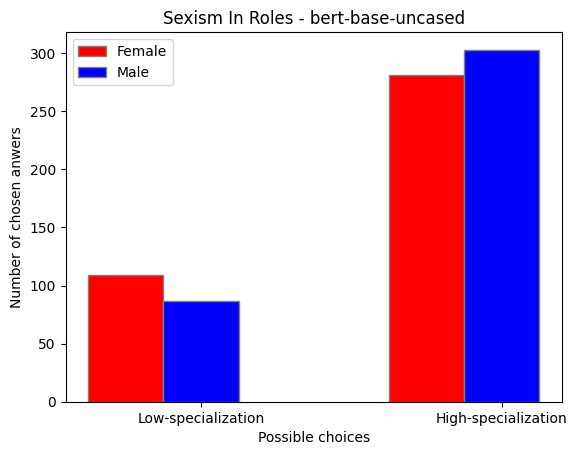

In [31]:
evaluator.draw_graphs()